# (논문) CAT/DOG_ver.3
> CNN and CAM _ 새로운 이미지로 해보기

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

**💀 writing에 정리를 한 번에 해보려고 했으나.. 결과가 너무 좋지 않아서 만든 실험용 노트**

### import 

In [488]:
import torch 
from fastai.vision.all import *
import cv2

---

### data 

In [5]:
path=untar_data(URLs.PETS)/'images'

In [6]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [7]:
files=get_image_files(path)

In [8]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [9]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

---

### learn

In [10]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

---

### sample

#### 1st CNN and CAM

In [53]:
get_image_files(path)[113]

Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Maine_Coon_61.jpg')

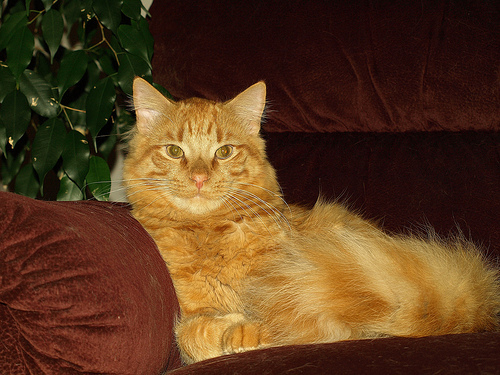

In [55]:
img = PILImage.create(get_image_files(path)[113])
img

In [56]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [493]:
print(torch.min(dls.train.decode((x,))[0].squeeze()))
print(torch.max(dls.train.decode((x,))[0].squeeze()))

print(torch.min(x))
print(torch.max(x))

TensorImage(0)
TensorImage(251)
TensorImage(-2.1179, device='cuda:0')
TensorImage(2.1804, device='cuda:0')


In [57]:
x.shape

torch.Size([1, 3, 512, 512])

In [42]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [43]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [44]:
net=torch.nn.Sequential(net1,net2)

In [45]:
lrnr2=Learner(dls,net,metrics=accuracy) 

- epoch수를 줄여본 결과 보다 결과가 개선된 모습

In [46]:
lrnr2.fine_tune(5) 

In [47]:
dls.vocab

['cat', 'dog']

- (고양이,강아지)라고 생각한 확률 

In [58]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

(0.9999999998182874, 1.8171263787640942e-10)

In [505]:
np.exp(a)

41041.7438618806

In [509]:
np.exp(b)

7.457803541545435e-06

In [507]:
net(x.to("cpu")).tolist()[0][0]

10.622979164123535

In [548]:
torch.mean(camimg[0])

tensor(10.6228, device='cuda:0', grad_fn=<MeanBackward0>)

In [552]:
torch.sum(camimg[0])/(16*16)

tensor(10.6228, device='cuda:0', grad_fn=<DivBackward0>)

In [508]:
net(x.to("cpu")).tolist()[0][1]

-11.806629180908203

- CAM

In [59]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

In [510]:
print(torch.min(camimg[1]))
print(torch.max(camimg[1]))
print(torch.mean(camimg[1]))

print(torch.min(camimg[0]))
print(torch.max(camimg[0]))
print(torch.mean(camimg[0]))

tensor(-192.8017, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0623, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-11.8065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4.1391, device='cuda:0', grad_fn=<MinBackward1>)
tensor(168.8966, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(10.6228, device='cuda:0', grad_fn=<MeanBackward0>)


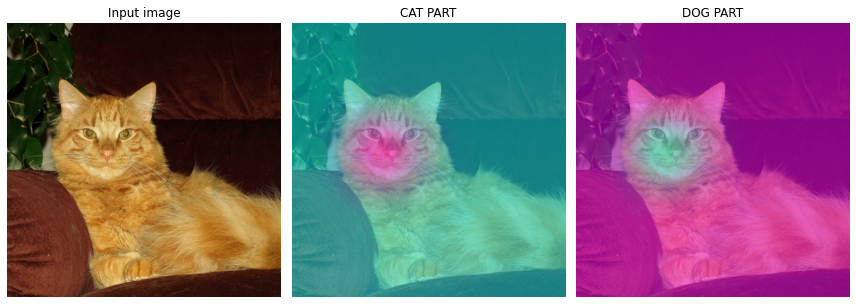

In [542]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

#### ★ **판단 근거가 강할수록 파란색 $\to$ 보라색 변함**

---

#### 2nd CNN and CAM

- MODE 1 만들기

    - 가중치 재설정

In [525]:
test=camimg[0]-torch.min(camimg[0])

In [637]:
camimg[0].shape

torch.Size([16, 16])

In [528]:
T=camimg[0]

In [378]:
A1=torch.exp(-0.015*test)  

In [638]:
A1.shape

torch.Size([16, 16])

In [529]:
T1=torch.exp(-0.015*T)

In [379]:
A2=1-A1

In [530]:
T2=1-T1

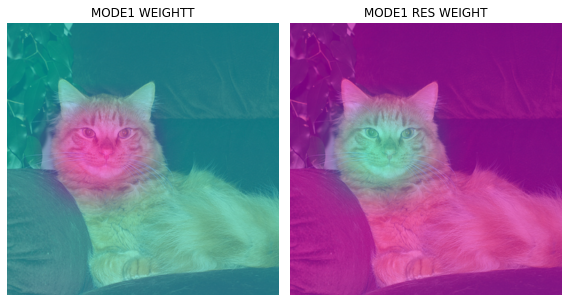

In [544]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHTT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

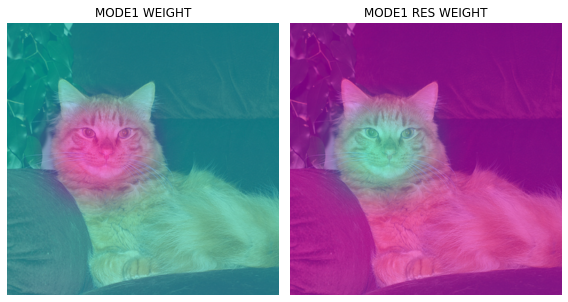

In [540]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(T2.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(T1.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [518]:
#mode1_res*x
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)

In [533]:
#T버젼 mode1_res*x
TX1=np.array(T1.to("cpu").detach(),dtype=np.float32)
TY1=torch.Tensor(cv2.resize(TX1,(512,512),interpolation=cv2.INTER_LINEAR))
Tx1=x.squeeze().to('cpu')*TY1-torch.min(x.squeeze().to('cpu')*TY1)

In [382]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv2.resize(X12,(512,512),interpolation=cv2.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12#-torch.min(x.squeeze().to('cpu')*Y12)

In [534]:
#mode1*x
TX12=np.array(T2.to("cpu").detach(),dtype=np.float32)
TY12=torch.Tensor(cv2.resize(TX12,(512,512),interpolation=cv2.INTER_LINEAR))
Tx12=x.squeeze().to('cpu')*TY12#-torch.min(x.squeeze().to('cpu')*Y12)

In [633]:
xx=x12+x1

- 여기서 mode res 만 minimum을 빼준 이유는 시각화할 때 까맣게 보이게 하기 위함!!

- 1st CAM 결과를 분리하면 아래와 같음.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

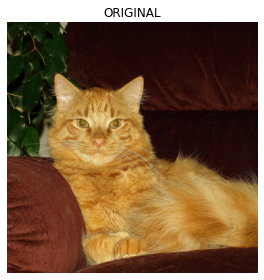

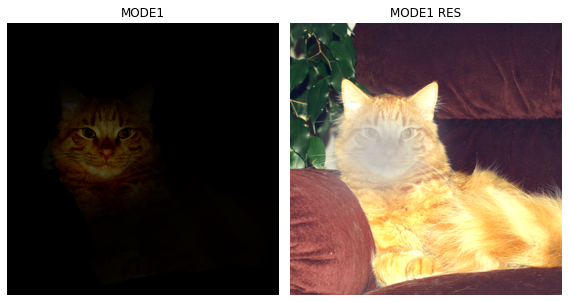

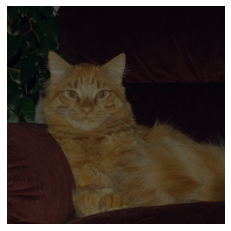

In [636]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.2).squeeze().show(ax=ax1)  #MODE1
(x1*0.35).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig,(ax1)=plt.subplots(1,1)
(xx*0.1).squeeze().show(ax=ax1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


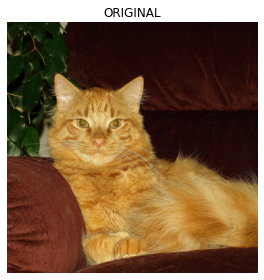

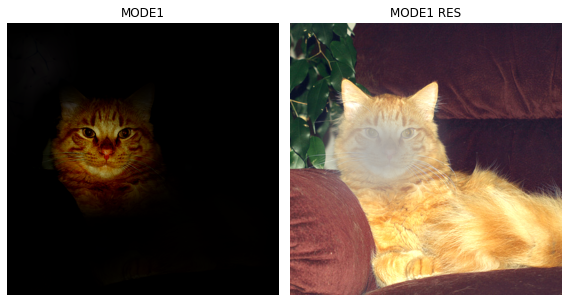

In [538]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(Tx12*0.4).squeeze().show(ax=ax1)  #MODE1
(Tx1*0.3).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

$\to$ `test`나 `T`나 별 차이가 없다..

In [384]:
x1=x1.reshape(1,3,512,512)

In [385]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [386]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

- CAM

    - mode1_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


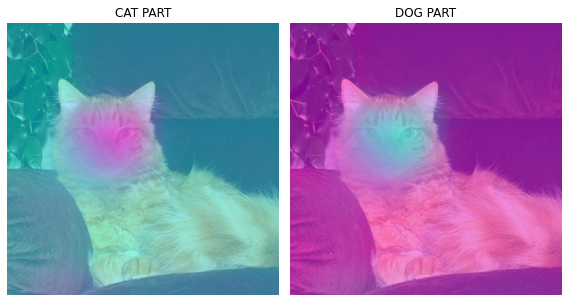

In [387]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
(x1*0.3).squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
(x1*0.3).squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째 CAM결과와 비교

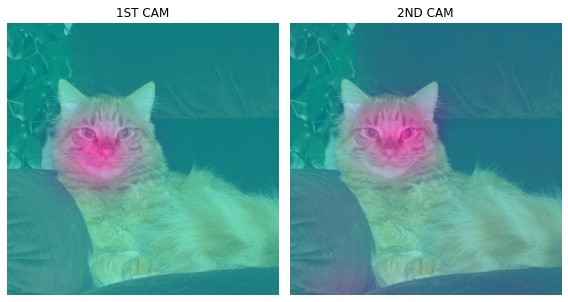

In [388]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [389]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(0.9658316715967996, 0.03416832840320044)

---

#### 3rd CNN and CAM

- MODE 2 만들기

In [390]:
test1=camimg1[0]-torch.min(camimg1[0])

In [602]:
A3=torch.exp(-0.06*test1)  

In [603]:
A4=1-A3

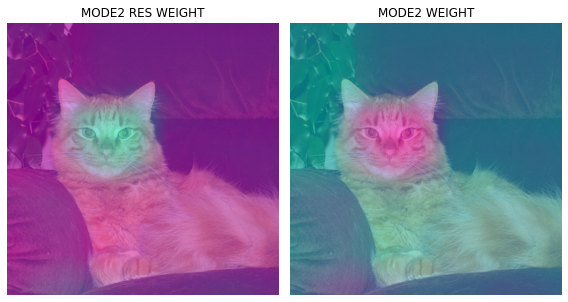

In [604]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE2 RES WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE2 WEIGHT")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [605]:
X2=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y2=torch.Tensor(cv2.resize(X2,(512,512),interpolation=cv2.INTER_LINEAR))
x2=(x1*0.35)*Y2-torch.min((x1*0.35)*Y2)

In [606]:
X22=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y22=torch.Tensor(cv2.resize(X22,(512,512),interpolation=cv2.INTER_LINEAR))
x22=(x1*0.35)*Y22#-torch.min((x1*0.35)*Y22)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


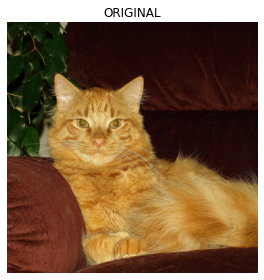

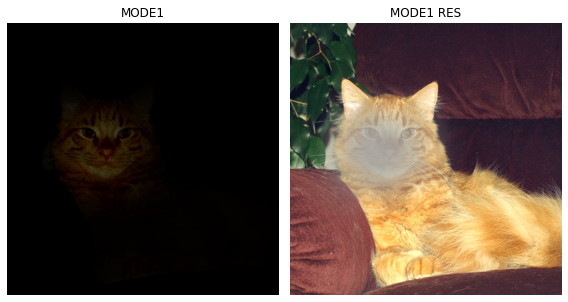

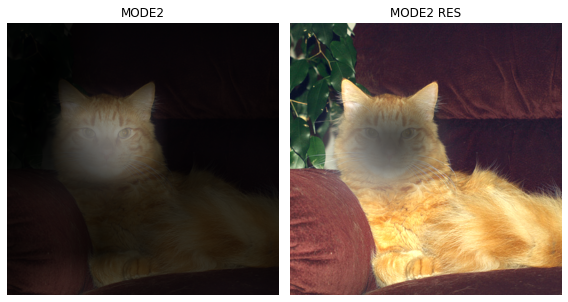

In [607]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.15).squeeze().show(ax=ax1)  #MODE1
(x1*0.3).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x22).squeeze().show(ax=ax1)  #MODE2
(x2).squeeze().show(ax=ax2)  #MODE2_res
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [608]:
x2=x2.reshape(1,3,512,512)

In [609]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [610]:
camimg2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x2).squeeze())

- CAM

    - mode2_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


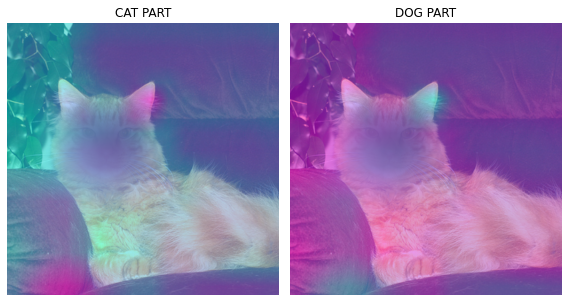

In [611]:
fig, (ax1, ax2) = plt.subplots(1,2) 
#
x2.squeeze().show(ax=ax1)
ax1.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x2.squeeze().show(ax=ax2)
ax2.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째, 두번째 CAM결과와 비교

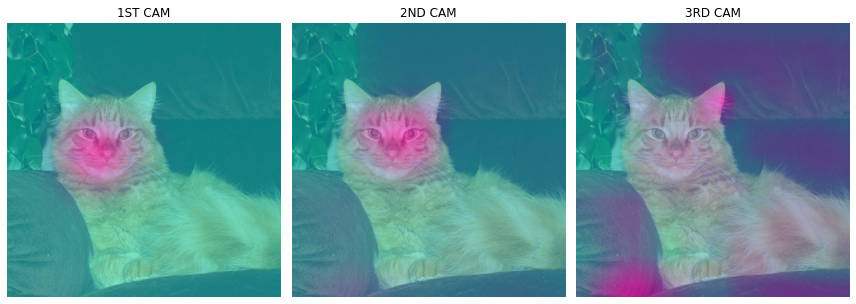

In [612]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

In [613]:
a2=net(x2).tolist()[0][0]
b2=net(x2).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(0.905214199073939, 0.09478580092606113)

---

#### 4th CNN and CAM

- MODE 3 만들기

In [614]:
test2=camimg2[0]-torch.min(camimg2[0])

In [615]:
A5=torch.exp(-0.3*test2)  

In [616]:
A6=1-A5

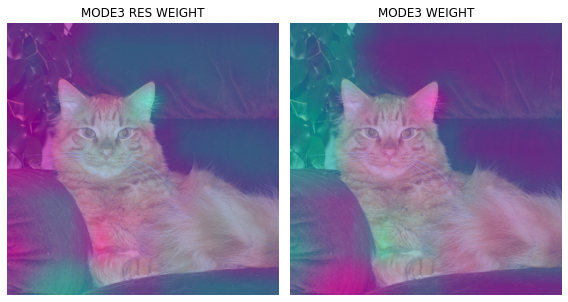

In [617]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A5.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE3 RES WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A6.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE3 WEIGHT")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [618]:
X3=np.array(A5.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv2.resize(X3,(512,512),interpolation=cv2.INTER_LINEAR))
x3=x2*Y3-torch.min(x2*Y3)

In [619]:
X32=np.array(A6.to("cpu").detach(),dtype=np.float32)
Y32=torch.Tensor(cv2.resize(X32,(512,512),interpolation=cv2.INTER_LINEAR))
x32=x2*Y32#-torch.min(x2*Y32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


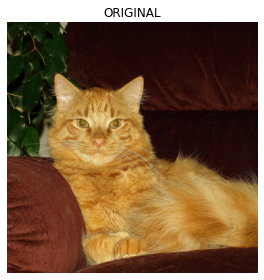

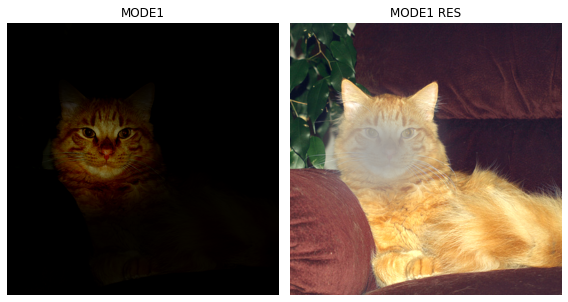

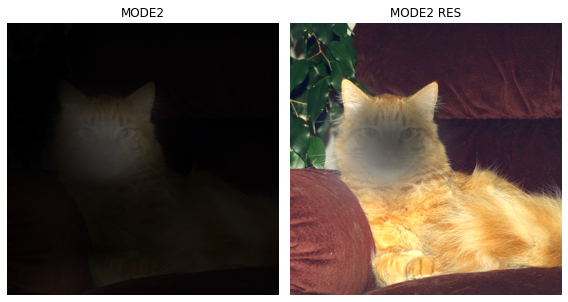

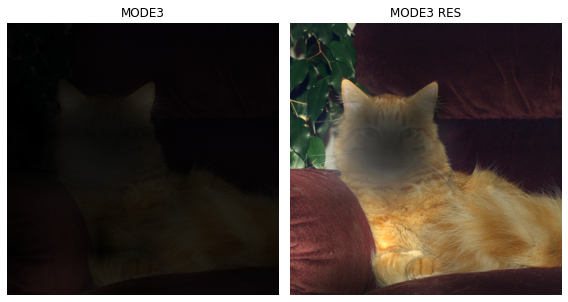

In [632]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.3).squeeze().show(ax=ax1)  #MODE1
(x1*0.3).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x22*0.5).squeeze().show(ax=ax1)  #MODE2
x2.squeeze().show(ax=ax2)  #MODE2_res
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x32*0.3).squeeze().show(ax=ax1)  #MODE3
(x3).squeeze().show(ax=ax2)  #MODE3_res
ax1.set_title("MODE3")
ax2.set_title("MODE3 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
plt.savefig('mode_cat')

In [621]:
x3=x3.reshape(1,3,512,512)

In [622]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [623]:
camimg3 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

- CAM

    - mode3_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


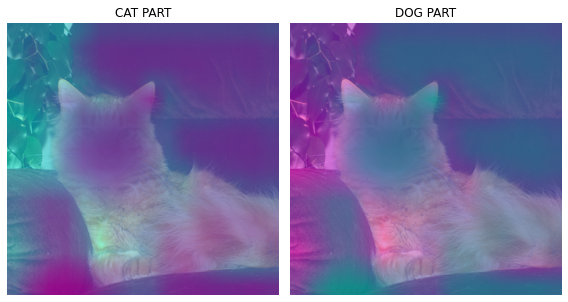

In [624]:
fig, (ax1, ax2) = plt.subplots(1,2) 
#
x3.squeeze().show(ax=ax1)
ax1.imshow(camimg3[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x3.squeeze().show(ax=ax2)
ax2.imshow(camimg3[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째, 두번째, 세번째 CAM결과와 비교

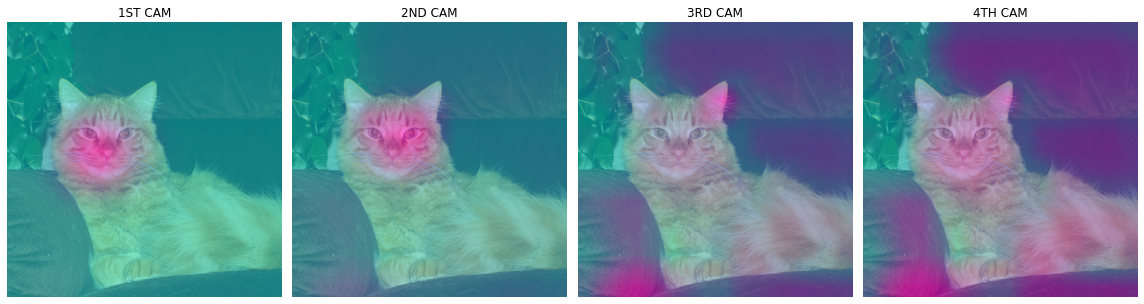

In [625]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax4)
ax4.imshow(camimg3[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax4.set_title("4TH CAM")
#
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [626]:
a3=net(x3).tolist()[0][0]
b3=net(x3).tolist()[0][1]
np.exp(a3)/(np.exp(a3)+np.exp(b3)), np.exp(b3)/(np.exp(a3)+np.exp(b3))

(0.9226089398162587, 0.07739106018374121)

---

### 25번 epoch 결과 

    - 첫번째, 두번째, 세번째 CAM결과와 비교

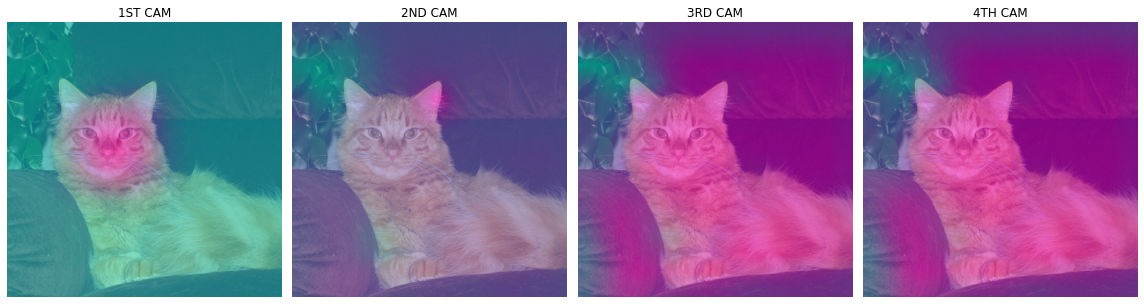

In [84]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax4)
ax4.imshow(camimg3[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax4.set_title("4TH CAM")
#
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [85]:
a3=net(x3).tolist()[0][0]
b3=net(x3).tolist()[0][1]
np.exp(a3)/(np.exp(a3)+np.exp(b3)), np.exp(b3)/(np.exp(a3)+np.exp(b3))

(0.918799098688349, 0.0812009013116511)

- 고양이는 오히려 마지막에 전체로 퍼져버리는 모습이 보임.